In [1]:
#importing data from kaggle ..........................
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:00<00:00, 178MB/s]
100% 60.3M/60.3M [00:00<00:00, 200MB/s]


In [5]:
!unzip /content/fer2013.zip -d /content/

Archive:  /content/fer2013.zip
replace /content/test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import os
#importgting all imp library....
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [7]:
#specifying test and test data .......
train_data ='/content/train'
test_data ='/content/test'

batch_size =64
# Rescale pixel values to [0,1]
 # Random rotation within range [-10,10] degrees
# Random zoom between [0.8, 1.2]
# Random horizontal shift within range [-0.1, 0.1]
 # Random vertical shift within range [-0.1, 0.1]
train_img_gen = ImageDataGenerator(rescale = 1./255,# Rescale pixel values to [0,1]
                                        rotation_range =10,
                                        zoom_range =0.2,
                                        brightness_range = None,
                                        width_shift_range =0.1,
                                        height_shift_range =0.1,
                                        horizontal_flip= True,
                                        fill_mode='nearest'
)


test_img_gen= ImageDataGenerator(rescale=1./255) # rescaleing to 0=1 range ....


In [8]:
#data genrator for train and test
train_genrator = train_img_gen.flow_from_directory(
    train_data, class_mode = 'categorical' , target_size = (224, 224) , color_mode = 'rgb',
    batch_size = batch_size, subset = 'training'
)


#for test data
test_genrator = test_img_gen.flow_from_directory(
    test_data , class_mode = 'categorical' , target_size = (224, 224) , color_mode = 'rgb',
    batch_size = batch_size

)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
#getting resnet50
ResNet50V2_model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False, # false  allow adding input and output layer...
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 0s 0us/step


In [10]:
#extract class labels in training
classes = np.array(train_genrator.classes)
 # Strategy to balance classes
class_weight =compute_class_weight(
    class_weight= 'balanced',  # i crete class weight to handle imbalanced data ...
    classes = np.unique(classes), # Unique class labels
    y = classes# Class labels for each instance in the training dataset
)





In [11]:
class_dict = dict(enumerate(class_weight))
print("Class Weights Dictionary:", class_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


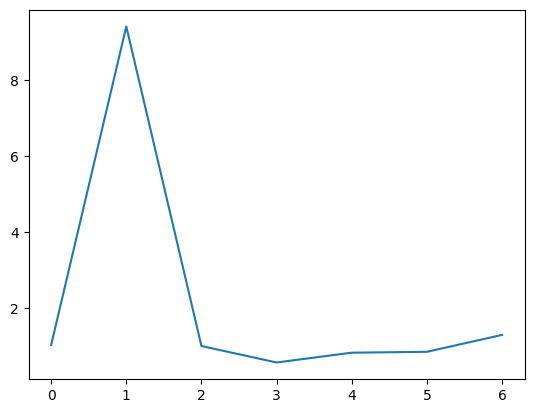

In [12]:
plt.plot(class_weight)

In [13]:
#now in resnet we freeze layers except last 50
ResNet50V2_model.trainable = True

for layer in ResNet50V2_model.layers[:-50]:
    layer.trainable = False

In [14]:
#resnet 50 model .... creating ...
model = Sequential([
                      ResNet50V2_model,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ]
                   )


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [16]:
#model compiling......
model.compile(optimizer = 'adam' , loss ='categorical_crossentropy' , metrics = 'accuracy')

In [17]:
path_cnn = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'model_wirh_resnet50'
join_path = os.path.join(path_cnn, name)
#callbacks to check model setpionts

checkpoint_callbacks = ModelCheckpoint(filepath = join_path , verbose = 1,
                                       mode = 'min', save_best_only = True,
                                        monitor= 'val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)
#call back for csv logger
csv_logger = CSVLogger(os.path.join(path_cnn,'training.log'))# Callback to log training data to a CSV file




In [18]:
# load all callbacks into a list
callbacks = [checkpoint_callbacks, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_genrator.samples // train_genrator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_genrator.samples // test_genrator.batch_size + 1

In [19]:
print(train_steps_per_epoch)
print(test_steps_epoch)

449
113


In [21]:
train_history = model.fit(
                          train_genrator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=5,
                          validation_data=test_genrator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_dict,
                          callbacks = callbacks
                         )

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.3729
Epoch 1: val_loss improved from inf to 20.70853, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/model_wirh_resnet50
449/449 [==============================] - 460s 1s/step - loss: 1.7823 - accuracy: 0.3729 - val_loss: 20.7085 - val_accuracy: 0.2644
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 1.4970 - accuracy: 0.4594
Epoch 2: val_loss improved from 20.70853 to 1.39417, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/model_wirh_resnet50
449/449 [==============================] - 450s 1s/step - loss: 1.4970 - accuracy: 0.4594 - val_loss: 1.3942 - val_accuracy: 0.5157
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 1.3581 - accuracy: 0.5001
Epoch 3: val_loss did not improve from 1.39417
449/449 [==============================] - 395s 880ms/step - loss: 1.3581 - accuracy: 0.5001 - val_loss

In [22]:
model.save("emotion_model.keras")

In [23]:
import keras

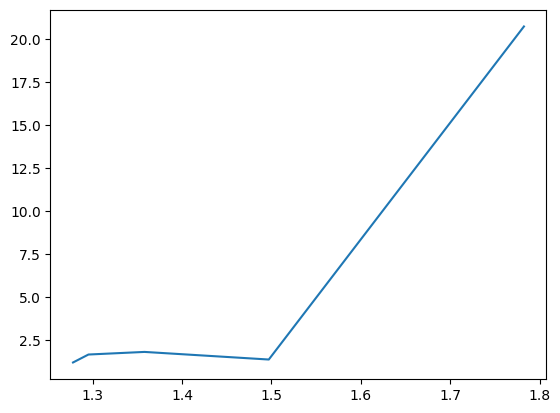

In [24]:
loss = train_history.history['loss']
val_accuracy = train_history.history['val_loss']

plt.plot(loss, val_accuracy)
plt.show()

In [25]:
take = keras.saving.load_model('/content/emotion_model.keras')

In [26]:
train_history = take.fit(
    train_genrator, steps_per_epoch=train_steps_per_epoch,
                          epochs=5,
                          validation_data=test_genrator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_dict,
                          callbacks = callbacks
                         )

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 1.1402 - accuracy: 0.5701
Epoch 1: val_loss improved from 1.22300 to 1.21992, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/model_wirh_resnet50
449/449 [==============================] - 428s 919ms/step - loss: 1.1402 - accuracy: 0.5701 - val_loss: 1.2199 - val_accuracy: 0.5556
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 1.0841 - accuracy: 0.5919
Epoch 2: val_loss improved from 1.21992 to 1.14713, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/model_wirh_resnet50
449/449 [==============================] - 420s 935ms/step - loss: 1.0841 - accuracy: 0.5919 - val_loss: 1.1471 - val_accuracy: 0.5762
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.5984
Epoch 3: val_loss improved from 1.14713 to 1.02076, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/model_wirh_r

In [27]:
test_loss, test_accu = model.evaluate(test_genrator)
print(test_loss, test_accu)

113/113 [==============================] - 20s 173ms/step - loss: 1.2230 - accuracy: 0.5435
1.2230010032653809 0.5434661507606506


In [28]:
#now print final printing train and test accuracy
train_loss, train_accu = model.evaluate(train_genrator)
test_loss, test_accu = model.evaluate(test_genrator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 20s 174ms/step - loss: 1.2230 - accuracy: 0.5435
final train accuracy = 55.22 , validation accuracy = 54.35


In [29]:

#im assuming true class and pridected is alredy defined
true_classes = test_genrator.classes
predicted_classes = np.argmax(model.predict(test_genrator, steps=np.ceil(test_genrator.samples/test_genrator.batch_size)), axis=1)
class_labels = list(test_genrator.class_indices.keys())


113/113 [==============================] - 21s 174ms/step


In [30]:
# Printing  classification report...understaing model performance
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.26      0.18       958
     disgust       0.02      0.11      0.04       111
        fear       0.12      0.05      0.08      1024
       happy       0.24      0.22      0.23      1774
     neutral       0.17      0.14      0.15      1233
         sad       0.16      0.09      0.12      1247
    surprise       0.11      0.13      0.12       831

    accuracy                           0.15      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.15      0.15      7178



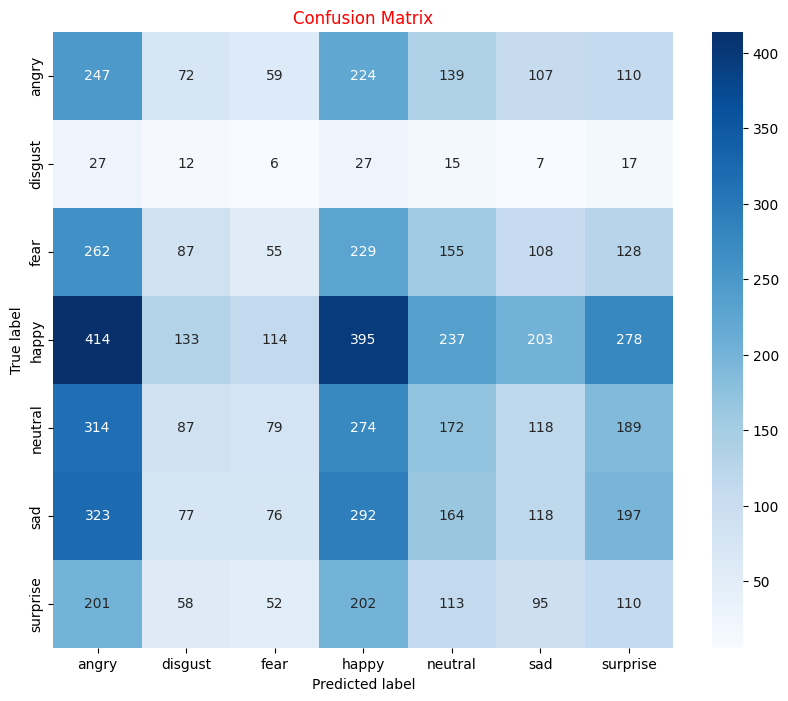

In [40]:
# now plotinng confusion matrix ...
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# using seaborn for plooting .....
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix' , color = 'red')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
#saving model with name resnet medel vrsion 2
model.save("Resnet_modelv2.keras")

In [43]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [44]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [46]:
!cp /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

cp: -r not specified; omitting directory '/content/FER_2013_Emotion_Detection'


In [ ]:
# time to deploy model....
